# Machine Translation + Transformer

In [172]:
# adjust python version as needed
# pip install torch torchvision torchaudio torchtext torchdata --index-url https://download.pytorch.org/whl/cpu
# pip install --upgrade numpy==1.26.4

In [173]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time
import pyidaungsu as pds
from torch.utils.data import DataLoader

In [174]:
print("MPS Available:", torch.backends.mps.is_available())

MPS Available: True


In [175]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [176]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [177]:
# torch.cuda.get_device_name(0)

In [178]:
torch.__version__

# torch.__version__
# '2.2.0'


'2.2.0'

In [179]:
torchtext.__version__
# torchtext.__version__
# '0.17.0'


'0.17.0'

In [180]:
torchdata.__version__

# torchdata.__version__
# '0.7.1'


'0.7.1'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [181]:
import pandas as pd

# Load Myanmar and English files
myanmar_file = "../alt/ALT.en-my.my"  # Myanmar text
english_file = "../alt/ALT.en-my.en"  # English text (ensure this is uploaded)

# Read the files line by line
with open(myanmar_file, "r", encoding="utf-8") as f_my, open(english_file, "r", encoding="utf-8") as f_en:
    myanmar_sentences = f_my.readlines()
    english_sentences = f_en.readlines()

# Create a Pandas DataFrame
df = pd.DataFrame({"en": english_sentences, "my": myanmar_sentences})

# Remove newlines and extra spaces
df["en"] = df["en"].str.strip()
df["my"] = df["my"].str.strip()

# Display the first few rows
print(df.head())


                                                  en  \
0  Italy have defeated Portugal 31-5 in Pool C of...   
1  Andrea Masi opened the scoring in the fourth m...   
2  Despite controlling the game for much of the f...   
3  Portugal never gave up and David Penalva score...   
4  Italy led 16-5 at half time but were matched b...   

                                                  my  
0  ပြင်သစ် နိုင်ငံ ပါရီ မြို့ ပါ့ဒက်စ် ပရင့်စက် ၌...  
1  အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ် မှု တစ် ...  
2  ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစား ပွဲ က...  
3  ပေါ်တူဂီ သည် ဘယ်သောအခါ မှ စွန့်လွှတ် မှု မ ရှိ...  
4  အီတလီ သည် ပထမပိုင်း ၌ ၁၆ - ၅ ဖြင့် ဦးဆောင် ခဲ့...  


In [182]:
# Save to a TSV file
df.to_csv("../alt/alt_my-en.tsv", sep="\t", index=False)


In [183]:
from datasets import Dataset, DatasetDict

# Convert Pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Split into Train, Validation, and Test
train_test_split = dataset.train_test_split(test_size=0.2)
train_val_split = train_test_split["train"].train_test_split(test_size=0.1)

dataset_dict = DatasetDict({
    "train": train_val_split["train"],
    "validation": train_val_split["test"],
    "test": train_test_split["test"]
})

# Save for later use
dataset_dict.save_to_disk("../alt/alt_dataset")


Saving the dataset (1/1 shards): 100%|██████████| 3618/3618 [00:00<00:00, 331991.33 examples/s]


In [184]:
corpus = dataset_dict

In [185]:
SRC_LANGUAGE = 'en' # English
TRG_LANGUAGE = 'my' # Myanmar

In [186]:
print(corpus['train'][0][SRC_LANGUAGE])
print(corpus['train'][0][TRG_LANGUAGE])

A centerpiece of the new policy is a new plan called the "Prompt Global Strike," which involves a new type of conventional weapon that could be fired from the U.S. and reach anywhere in the world within an hour, providing an effective option for attacks worldwide, such as against a missile launch from North Korea or a strike against Al-Qaeda in Pakistan.
မူဝါဒ သစ် ၏ အဓိက အခန်း ကဏ္ဍ တစ် ခု မှာ မြောက် ကိုရီးယား မှ ဒုံးကျည် ပစ်လွှတ် ခြင်း တစ် ခု ကို ဆန့်ကျင် လျက် သို့မဟုတ် ပါကစ္စတန် တွင် အယ်လ်ကိုင်ဒါ ကို ဆန့်ကျင် လျက် တိုက်ဖျက် မှု တစ် ခု ကဲ့သို့ ၊ ကမ္ဘာ အနှံ့ တွင် တိုက်ခိုက် မှု များ အတွက် အကျိုးထိရောက် သော ရွေးချယ် မှု တစ် ခု ပေး ခြင်း ၊ ကမ္ဘာ ပေါ်ရှိ မည်သည့် နေရာ ကို မဆို တစ် နာရီ အတွင်း ရောက် ရှိ ပြီး အမေရိကန် ပြည်ထောင်စု မှ ပစ်ခတ် နိုင် သည့် သမားရိုးကျ လက်နက် ၏ ပုံစံ သစ် တစ် မျိုး ပါဝင် သော “ လျင်မြန် သော ကမ္ဘာ အနှံ့ ရိုက်ခတ် မှု ” ၊ ဟု ခေါ် သော အစီအစဉ် သစ် တစ် ခု ဖြစ် သည် ။


In [187]:
# from sacremoses import MosesTokenizer

# tokenizer = MosesTokenizer(lang='my')
# text = "မင်္ဂလာပါ။ သင့်အနေနဲ့မြန်မာဘာသာစကားကိုလေ့လာနေပါသလား။"
# tokens = tokenizer.tokenize(text)

# print(tokens)  # ['မင်္ဂလာပါ', '။', 'သင့်', 'အနေနဲ့', 'မြန်မာ', 'ဘာသာစကား', 'ကို', 'လေ့လာ', 'နေပါသလား', '။']


In [188]:
# print(fleurs.features['transcription'])

In [189]:
# dataloader = DataLoader(fleurs, batch_size=32)

In [190]:
# print(next(iter(fleurs)))

In [191]:
# ## testing with the opus100 dataset

# from datasets import load_dataset

# # SRC_LANGUAGE = 'en'
# # TRG_LANGUAGE = 'my'  # Myanmar language code

# # Load OPUS Myanmar-English dataset
# dataset = load_dataset("opus100", "en-my")

# # Get train, validation, and test splits
# # train = dataset["train"]
# # val = dataset["validation"]
# # test = dataset["test"]


In [192]:
# train = [(row['en'], row['my']) for row in dataset['train']['translation']]
# val = [(row['en'], row['my']) for row in dataset['validation']['translation']]
# test = [(row['en'], row['my']) for row in dataset['test']['translation']]

# # Print a sample
# print(train[1])  # {'translation': {'en': 'Hello', 'my': 'မင်္ဂလာပါ'}}

In [193]:
# train

In [194]:
# next(iter(train))

In [195]:
# type(dataset['train'])

In [196]:
# from torchtext.datasets import Multi30k

# # SRC_LANGUAGE = 'en'
# # TRG_LANGUAGE = 'de'

# train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

# # Print a sample
# print(train[0])  # {'translation': {'en': 'Hello', 'my': 'မင်္ဂလာပါ'}}
# print(train[0].__dict__.keys())

In [197]:
# #so this is a datapipe object; very similar to pytorch dataset version 2 which is better
# train

## 2. EDA - simple investigation

In [198]:
# #let's take a look at one example of train
# sample = next(iter(train))
# sample

sample = corpus['train'][0][TRG_LANGUAGE]
sample

'မူဝါဒ သစ် ၏ အဓိက အခန်း ကဏ္ဍ တစ် ခု မှာ မြောက် ကိုရီးယား မှ ဒုံးကျည် ပစ်လွှတ် ခြင်း တစ် ခု ကို ဆန့်ကျင် လျက် သို့မဟုတ် ပါကစ္စတန် တွင် အယ်လ်ကိုင်ဒါ ကို ဆန့်ကျင် လျက် တိုက်ဖျက် မှု တစ် ခု ကဲ့သို့ ၊ ကမ္ဘာ အနှံ့ တွင် တိုက်ခိုက် မှု များ အတွက် အကျိုးထိရောက် သော ရွေးချယ် မှု တစ် ခု ပေး ခြင်း ၊ ကမ္ဘာ ပေါ်ရှိ မည်သည့် နေရာ ကို မဆို တစ် နာရီ အတွင်း ရောက် ရှိ ပြီး အမေရိကန် ပြည်ထောင်စု မှ ပစ်ခတ် နိုင် သည့် သမားရိုးကျ လက်နက် ၏ ပုံစံ သစ် တစ် မျိုး ပါဝင် သော “ လျင်မြန် သော ကမ္ဘာ အနှံ့ ရိုက်ခတ် မှု ” ၊ ဟု ခေါ် သော အစီအစဉ် သစ် တစ် ခု ဖြစ် သည် ။'

In [199]:
# sample['translation']['my']
sample[1]

'ူ'

In [200]:
corpus

DatasetDict({
    train: Dataset({
        features: ['en', 'my'],
        num_rows: 13023
    })
    validation: Dataset({
        features: ['en', 'my'],
        num_rows: 1448
    })
    test: Dataset({
        features: ['en', 'my'],
        num_rows: 3618
    })
})

In [201]:
# train_size = len(list(iter(train)))
# train_size

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [202]:
train = corpus['train']
val = corpus['validation']
test = corpus['test']

In [203]:
train_size = corpus['train'].shape[0]
train_size

13023

In [204]:
val_size = corpus['validation'].shape[0]
val_size

1448

In [205]:
test_size = corpus['test'].shape[0]
test_size

3618

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [206]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [207]:
# Myanmar word tokenizer.
def my_tokenizer(sentence):
    return pds.tokenize(sentence, form="word")

In [208]:
my_tokenizer(sample) 

['မူဝါဒ',
 'သစ်',
 '၏',
 'အဓိက',
 'အခန်း',
 'ကဏ္ဍ',
 'တစ်',
 'ခု',
 'မှာ',
 'မြောက်',
 'ကိုရီးယား',
 'မှ',
 'ဒုံးကျည်',
 'ပစ်လွှတ်',
 'ခြင်း',
 'တစ်',
 'ခု',
 'ကို',
 'ဆန့်',
 'ကျင်',
 'လျက်',
 'သို့မဟုတ်',
 'ပါကစ္စတန်',
 'တွင်',
 'အယ်လ်ကိုင်ဒါ',
 'ကို',
 'ဆန့်',
 'ကျင်',
 'လျက်',
 'တိုက်',
 'ဖျက်',
 'မှု',
 'တစ်',
 'ခု',
 'ကဲ့သို့',
 '၊',
 'ကမ္ဘာ',
 'အနှံ့',
 'တွင်',
 'တိုက်ခိုက်',
 'မှု',
 'များ',
 'အတွက်',
 'အကျိုး',
 'ထိရောက်',
 'သော',
 'ရွေးချယ်',
 'မှု',
 'တစ်',
 'ခု',
 'ပေး',
 'ခြင်း',
 '၊',
 'ကမ္ဘာ',
 'ပေါ်',
 'ရှိ',
 'မည်',
 'သည့်',
 'နေရာ',
 'ကို',
 'မ',
 'ဆို',
 'တစ်',
 'နာရီ',
 'အတွင်းရောက်',
 'ရှိ',
 'ပြီး',
 'အမေရိကန်',
 'ပြည်ထောင်စု',
 'မှ',
 'ပစ်ခတ်',
 'နိုင်',
 'သည့်သမားရိုးကျ',
 'လက်နက်',
 '၏',
 'ပုံစံ',
 'သစ်',
 'တစ်',
 'မျိုး',
 'ပါဝင်',
 'သော',
 '“',
 'လျင်မြန်',
 'သော',
 'ကမ္ဘာ',
 'အနှံ့ရိုက်ခတ်',
 'မှု',
 '”',
 '၊',
 'ဟု',
 'ခေါ်',
 'သော',
 'အစီအစဉ်',
 'သစ်',
 'တစ်',
 'ခု',
 'ဖြစ်',
 'သည်',
 '။']

In [209]:
from torchtext.data.utils import get_tokenizer

SRC_LANGUAGE = 'my'  # Myanmar language
TRG_LANGUAGE = 'en'  # English language (assuming translation to English)

# token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
# token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

token_transform[SRC_LANGUAGE] = my_tokenizer  # Myanmar tokenizer
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')  # English tokenizer

# Print updated code
print("Updated code:")
#print(f"token_transform[{SRC_LANGUAGE}] = torchtext_data.get_tokenizer('spacy', language='myanmar_nltk')")
print(f"token_transform[{TRG_LANGUAGE}] = torchtext_data.get_tokenizer('spacy', language='en_core_web_sm')")


Updated code:
token_transform[en] = torchtext_data.get_tokenizer('spacy', language='en_core_web_sm')


In [210]:
print(corpus['train'][0][SRC_LANGUAGE])
print(corpus['train'][0][TRG_LANGUAGE])

မူဝါဒ သစ် ၏ အဓိက အခန်း ကဏ္ဍ တစ် ခု မှာ မြောက် ကိုရီးယား မှ ဒုံးကျည် ပစ်လွှတ် ခြင်း တစ် ခု ကို ဆန့်ကျင် လျက် သို့မဟုတ် ပါကစ္စတန် တွင် အယ်လ်ကိုင်ဒါ ကို ဆန့်ကျင် လျက် တိုက်ဖျက် မှု တစ် ခု ကဲ့သို့ ၊ ကမ္ဘာ အနှံ့ တွင် တိုက်ခိုက် မှု များ အတွက် အကျိုးထိရောက် သော ရွေးချယ် မှု တစ် ခု ပေး ခြင်း ၊ ကမ္ဘာ ပေါ်ရှိ မည်သည့် နေရာ ကို မဆို တစ် နာရီ အတွင်း ရောက် ရှိ ပြီး အမေရိကန် ပြည်ထောင်စု မှ ပစ်ခတ် နိုင် သည့် သမားရိုးကျ လက်နက် ၏ ပုံစံ သစ် တစ် မျိုး ပါဝင် သော “ လျင်မြန် သော ကမ္ဘာ အနှံ့ ရိုက်ခတ် မှု ” ၊ ဟု ခေါ် သော အစီအစဉ် သစ် တစ် ခု ဖြစ် သည် ။
A centerpiece of the new policy is a new plan called the "Prompt Global Strike," which involves a new type of conventional weapon that could be fired from the U.S. and reach anywhere in the world within an hour, providing an effective option for attacks worldwide, such as against a missile launch from North Korea or a strike against Al-Qaeda in Pakistan.


In [211]:
print("Sentence: ", corpus['train'][0][SRC_LANGUAGE])
print("Tokenization: ", token_transform[SRC_LANGUAGE](corpus['train'][0][SRC_LANGUAGE]))

Sentence:  မူဝါဒ သစ် ၏ အဓိက အခန်း ကဏ္ဍ တစ် ခု မှာ မြောက် ကိုရီးယား မှ ဒုံးကျည် ပစ်လွှတ် ခြင်း တစ် ခု ကို ဆန့်ကျင် လျက် သို့မဟုတ် ပါကစ္စတန် တွင် အယ်လ်ကိုင်ဒါ ကို ဆန့်ကျင် လျက် တိုက်ဖျက် မှု တစ် ခု ကဲ့သို့ ၊ ကမ္ဘာ အနှံ့ တွင် တိုက်ခိုက် မှု များ အတွက် အကျိုးထိရောက် သော ရွေးချယ် မှု တစ် ခု ပေး ခြင်း ၊ ကမ္ဘာ ပေါ်ရှိ မည်သည့် နေရာ ကို မဆို တစ် နာရီ အတွင်း ရောက် ရှိ ပြီး အမေရိကန် ပြည်ထောင်စု မှ ပစ်ခတ် နိုင် သည့် သမားရိုးကျ လက်နက် ၏ ပုံစံ သစ် တစ် မျိုး ပါဝင် သော “ လျင်မြန် သော ကမ္ဘာ အနှံ့ ရိုက်ခတ် မှု ” ၊ ဟု ခေါ် သော အစီအစဉ် သစ် တစ် ခု ဖြစ် သည် ။
Tokenization:  ['မူဝါဒ', 'သစ်', '၏', 'အဓိက', 'အခန်း', 'ကဏ္ဍ', 'တစ်', 'ခု', 'မှာ', 'မြောက်', 'ကိုရီးယား', 'မှ', 'ဒုံးကျည်', 'ပစ်လွှတ်', 'ခြင်း', 'တစ်', 'ခု', 'ကို', 'ဆန့်', 'ကျင်', 'လျက်', 'သို့မဟုတ်', 'ပါကစ္စတန်', 'တွင်', 'အယ်လ်ကိုင်ဒါ', 'ကို', 'ဆန့်', 'ကျင်', 'လျက်', 'တိုက်', 'ဖျက်', 'မှု', 'တစ်', 'ခု', 'ကဲ့သို့', '၊', 'ကမ္ဘာ', 'အနှံ့', 'တွင်', 'တိုက်ခိုက်', 'မှု', 'များ', 'အတွက်', 'အကျိုး', 'ထိရောက်', 'သော', 'ရွေးချယ်', 'မှု', 'တစ်', 'ခု', 'ပေး', 'ခြ

In [212]:
print("Sentence: ", corpus['train'][0][TRG_LANGUAGE])
print("Tokenization: ", token_transform[TRG_LANGUAGE](corpus['train'][0][TRG_LANGUAGE]))

Sentence:  A centerpiece of the new policy is a new plan called the "Prompt Global Strike," which involves a new type of conventional weapon that could be fired from the U.S. and reach anywhere in the world within an hour, providing an effective option for attacks worldwide, such as against a missile launch from North Korea or a strike against Al-Qaeda in Pakistan.
Tokenization:  ['A', 'centerpiece', 'of', 'the', 'new', 'policy', 'is', 'a', 'new', 'plan', 'called', 'the', '"', 'Prompt', 'Global', 'Strike', ',', '"', 'which', 'involves', 'a', 'new', 'type', 'of', 'conventional', 'weapon', 'that', 'could', 'be', 'fired', 'from', 'the', 'U.S.', 'and', 'reach', 'anywhere', 'in', 'the', 'world', 'within', 'an', 'hour', ',', 'providing', 'an', 'effective', 'option', 'for', 'attacks', 'worldwide', ',', 'such', 'as', 'against', 'a', 'missile', 'launch', 'from', 'North', 'Korea', 'or', 'a', 'strike', 'against', 'Al', '-', 'Qaeda', 'in', 'Pakistan', '.']


In [213]:
# #example of tokenization of the english part
# print("Sentence: ", "မင်္ဂလာပါ၊ ကျေးဇူးတင်ပါတယ်။")
# print("Tokenization: ", token_transform[SRC_LANGUAGE]("မင်္ဂလာပါ၊ ကျေးဇူးတင်ပါတယ်။"))

In [214]:
token_transform['en']

functools.partial(<function _spacy_tokenize at 0x15d1ebd00>, spacy=<spacy.lang.en.English object at 0x15eea6380>)

In [215]:
# from torchtext.data.utils import get_tokenizer
# token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
# token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [216]:
#example of tokenization of the english part
print("Sentence: ", sample)
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample))

Sentence:  မူဝါဒ သစ် ၏ အဓိက အခန်း ကဏ္ဍ တစ် ခု မှာ မြောက် ကိုရီးယား မှ ဒုံးကျည် ပစ်လွှတ် ခြင်း တစ် ခု ကို ဆန့်ကျင် လျက် သို့မဟုတ် ပါကစ္စတန် တွင် အယ်လ်ကိုင်ဒါ ကို ဆန့်ကျင် လျက် တိုက်ဖျက် မှု တစ် ခု ကဲ့သို့ ၊ ကမ္ဘာ အနှံ့ တွင် တိုက်ခိုက် မှု များ အတွက် အကျိုးထိရောက် သော ရွေးချယ် မှု တစ် ခု ပေး ခြင်း ၊ ကမ္ဘာ ပေါ်ရှိ မည်သည့် နေရာ ကို မဆို တစ် နာရီ အတွင်း ရောက် ရှိ ပြီး အမေရိကန် ပြည်ထောင်စု မှ ပစ်ခတ် နိုင် သည့် သမားရိုးကျ လက်နက် ၏ ပုံစံ သစ် တစ် မျိုး ပါဝင် သော “ လျင်မြန် သော ကမ္ဘာ အနှံ့ ရိုက်ခတ် မှု ” ၊ ဟု ခေါ် သော အစီအစဉ် သစ် တစ် ခု ဖြစ် သည် ။
Tokenization:  ['မူဝါဒ', 'သစ်', '၏', 'အဓိက', 'အခန်း', 'ကဏ္ဍ', 'တစ်', 'ခု', 'မှာ', 'မြောက်', 'ကိုရီးယား', 'မှ', 'ဒုံးကျည်', 'ပစ်လွှတ်', 'ခြင်း', 'တစ်', 'ခု', 'ကို', 'ဆန့်', 'ကျင်', 'လျက်', 'သို့မဟုတ်', 'ပါကစ္စတန်', 'တွင်', 'အယ်လ်ကိုင်ဒါ', 'ကို', 'ဆန့်', 'ကျင်', 'လျက်', 'တိုက်', 'ဖျက်', 'မှု', 'တစ်', 'ခု', 'ကဲ့သို့', '၊', 'ကမ္ဘာ', 'အနှံ့', 'တွင်', 'တိုက်ခိုက်', 'မှု', 'များ', 'အတွက်', 'အကျိုး', 'ထိရောက်', 'သော', 'ရွေးချယ်', 'မှု', 'တစ်', 'ခု', 'ပေး', 'ခြ

A function to tokenize our input.

In [217]:
# # helper function to yield list of tokens
# # here data can be `train` or `val` or `test`
# def yield_tokens(data, language):
#     language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

#     for data_sample in data:
#         yield token_transform[language](data_sample[language_index[language]]) #either first or second index

In [218]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    if data is None: # handle null value
        return []
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if isinstance(data_sample, list): # handle list
            yield token_transform[language](data_sample[language_index[language]])
        elif isinstance(data_sample, dict):
            yield token_transform[language](data_sample[language])

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [219]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [220]:
train

Dataset({
    features: ['en', 'my'],
    num_rows: 13023
})

In [221]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [222]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[0, 0, 0, 0, 0]

In [223]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'တိုးရီးယား'

In [224]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [225]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [226]:
#check unique vocabularies
len(mapping)

10112

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [227]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [228]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [229]:
for en, _, de in train_loader:
    break

In [230]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("German shape: ", de.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 3])
German shape:  torch.Size([64, 3])


## 5. Design the model

### Encoder Layer

In [231]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [232]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [233]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [234]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [235]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [236]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [237]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [238]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
    

In [239]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [240]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10112, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
  

In [241]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

2588672
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3622400
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3622400
 14150
______
13852486


In [242]:
# pip install torch==2.2.0 torchdata==0.10.1 torchtext==0.6.0 

In [243]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10112, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
  

In [244]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [245]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [246]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [247]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [248]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [249]:
best_valid_loss = float('inf')
num_epochs = 1
clip       = 1

save_path = f'app/models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 19s
	Train Loss: 0.753 | Train PPL:   2.123
	 Val. Loss: 0.001 |  Val. PPL:   1.001


Text(0, 0.5, 'loss')

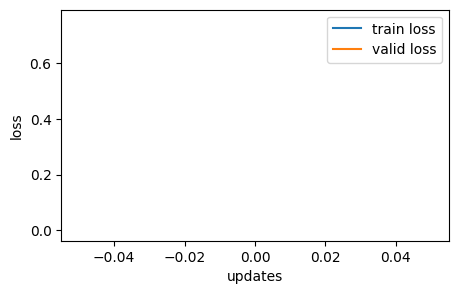

In [250]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [251]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.001 | Test PPL:   1.001 |


## 7. Test on some random news

In [252]:
sample

'မူဝါဒ သစ် ၏ အဓိက အခန်း ကဏ္ဍ တစ် ခု မှာ မြောက် ကိုရီးယား မှ ဒုံးကျည် ပစ်လွှတ် ခြင်း တစ် ခု ကို ဆန့်ကျင် လျက် သို့မဟုတ် ပါကစ္စတန် တွင် အယ်လ်ကိုင်ဒါ ကို ဆန့်ကျင် လျက် တိုက်ဖျက် မှု တစ် ခု ကဲ့သို့ ၊ ကမ္ဘာ အနှံ့ တွင် တိုက်ခိုက် မှု များ အတွက် အကျိုးထိရောက် သော ရွေးချယ် မှု တစ် ခု ပေး ခြင်း ၊ ကမ္ဘာ ပေါ်ရှိ မည်သည့် နေရာ ကို မဆို တစ် နာရီ အတွင်း ရောက် ရှိ ပြီး အမေရိကန် ပြည်ထောင်စု မှ ပစ်ခတ် နိုင် သည့် သမားရိုးကျ လက်နက် ၏ ပုံစံ သစ် တစ် မျိုး ပါဝင် သော “ လျင်မြန် သော ကမ္ဘာ အနှံ့ ရိုက်ခတ် မှု ” ၊ ဟု ခေါ် သော အစီအစဉ် သစ် တစ် ခု ဖြစ် သည် ။'

In [253]:
sample[1]

'ူ'

In [275]:
src_text = text_transform[SRC_LANGUAGE](sample).to(device)
src_text

tensor([   2,  538,  610,   12,  196,  670,  663,   15,   20,   31,  190,  746,
          25, 1094, 1351,   21,   15,   20,    6,  158,  171,  248,  141,  561,
          14, 9650,    6,  158,  171,  248,  285,  731,   13,   15,   20,  179,
           7,  258, 1083,   14,  131,   13,    9,   35,  429, 1131,   10,  415,
          13,   15,   20,   45,   21,    7,  258,   97,   18,   41,   38,   68,
           6,   27,   74,   15,  143, 9456,   18,   22,   73,  191,   25,  459,
          42,    0,  288,   12,  386,  610,   15,  504,  101,   10,   36,  846,
          10,  258,    0,   13,   44,    7,   28,  324,   10,  168,  610,   15,
          20,   19,    4,    8,    3], device='mps:0')

In [276]:
trg_text = text_transform[TRG_LANGUAGE](sample).to(device)
trg_text

tensor([  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 918,   0,   0,   0,   0,   0,   0,
        710,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3],
       device='mps:0')

In [256]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [257]:
trg_text = trg_text.reshape(1, -1)

In [258]:
src_text.shape, trg_text.shape

(torch.Size([1, 101]), torch.Size([1, 97]))

In [259]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [260]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [261]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 97, 14150])

Since batch size is 1, we just take off that dimension

In [262]:
output = output.squeeze(0)

In [263]:
output.shape

torch.Size([97, 14150])

We shall remove the first token since it's zeroes anyway

In [264]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([96, 14150])

Then we just take the top token with highest probabilities

In [265]:
output_max = output.argmax(1) #returns max indices

In [266]:
output_max

tensor([313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313,
        313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
       device='mps:0')

Get the mapping of the target language

In [267]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [268]:
for token in output_max:
    print(mapping[token.item()])

my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
my
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [269]:
attentions.shape

torch.Size([1, 8, 97, 101])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [270]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([97, 101])

In [271]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>', 'မ', '<eos>']

In [272]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 'my',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>']

In [273]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/var/folders/5n/px4p2nf95mq6g8zzrtlxc8pw0000gn/T/ipykernel_1564/59549304.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/5n/px4p2nf95mq6g8zzrtlxc8pw0000gn/T/ipykernel_1564/59549304.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 4121 (\N{MYANMAR LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


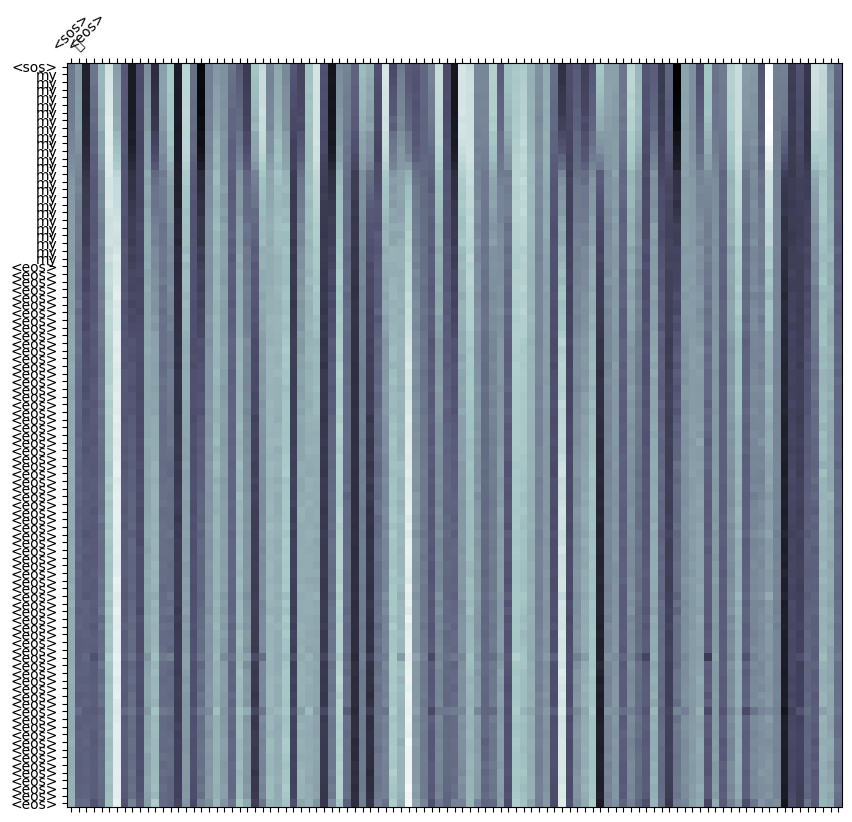

In [274]:
display_attention(src_tokens, trg_tokens, attention)